In [2]:
import pandas as pd 
import numpy as np 
import src.tools.download as download
from src import get_sequence_identities
from src.tools import MMSeqs, Prodigal
from src.tools.prodigal import remove_asterisks
from src.dataset import Dataset
from src.files import FASTAFile, XMLFile, InterProScanFile
from src.reference import Reference
from src.clusterer import Clusterer
from tqdm import tqdm
import os
import subprocess
import json 
from src.reference import compare
import seaborn as sns
from src import fillna 
import matplotlib.pyplot as plt
import matplotlib.ticker as tick 
from utils import * 
import re

%load_ext autoreload
%autoreload 2

# Downloaded AntiFam-annotated sequences from InterPro on 04.08.2025.   

# TODO: There are partial sequences in the training dataset (at least in the spurious class). I am not sure if these are a good idea to
#   include, as there are no partial translations from Prodigal (except sometimes on the edges). How much does start codon value
#   affect the embedding?
# TODO: Should remind myself how I got all of the genome metadata. I think I just downloaded directly from the NCBI Datasets website.
# TODO: What proportion of PGAP-annotated genomes rely on ab initio evidence?

In [ ]:
def merge_xml(path:str, output_path:str=None):
    '''When the XML entries are downloaded in chunks, the XMLTree parser freaks out ("Extra content at the end of document" error).
    Need to make sure there is only one XML declaration line (e.g., "<?xml version="1.0" encoding="UTF-8"  standalone="no" ?>") at 
    the top of the file, and only one root node (with the "uniprot" tag).'''
    with open(path, 'r') as f:
        lines = f.readlines()
    n_lines = len(lines)
    remove_line = lambda i, line : ((i > 0) and ('<?xml' in line)) or ((i < (n_lines - 1)) and ('</uniprot>' in line) or ((i > 1)) and ('<uniprot' in line))
    lines = [line for i, line in enumerate(lines) if (not remove_line(i, line))]
    with open(output_path, 'w') as f:
        f.write(''.join(lines))
    print(f'merge_xml: Cleaned-up XML file written to {output_path}')

merge_xml: Cleaned-up XML file written to ../data/antifam_interpro.xml


In [ ]:
def get_interpro_antifam():

    antifam = download.AntiFam()
    antifam.get_antifam_ids('../data/antifam_ids.json')
    with open('../data/antifam_ids.json', 'r') as f:
        antifam_ids = json.load(f)
        antifam_ids = [entry['id'] for entry in antifam_ids]
    antifam.get_proteins(antifam_ids=antifam_ids, path='../data/_antifam_interpro.csv')
    antifam_df = pd.read_csv('../data/_antifam_interpro.csv', index_col=0)

    uniprot = download.UniProt()
    uniprot.get_proteins(antifam_df.index, format_='xml', chunk_size=50, path='../data/antifam_interpro.xml')
    merge_xml('../data/antifam_interpro.xml', output_path='../data/antifam_interpro.xml')

    XMLFile('../data/antifam_interpro.xml').to_df().to_csv('../data/antifam_interpro.csv')

    antifam_df = pd.read_csv('../data/antifam_interpro.csv', index_col=0)
    bacteria_antifam_df = antifam_df[antifam_df.domain == 'Bacteria'].copy()
    bacteria_antifam_df.to_csv('../data/antifam_interpro_bacteria.csv')

In [ ]:
def get_uniprot_antifam():
    # Obtained bacterial sequences with an AntiFam database hit directly from the UniProt website on 04.08.2025. 
    bacteria_antifam_df = XMLFile('../data/antifam_uniprot_bacteria.xml').to_df()
    bacteria_antifam_df.to_csv('../data/antifam_uniprot_bacteria.csv')

XMLFile.__init__: Parsing XML file, row 17909.: : 2418316it [00:36, 66446.12it/s]


In [13]:
# There are some sequences which are annotated with AntiFam in UniProt, and others in the InterPro database which 
# are marked as AntiFam, but are not marked as AntiFam in UniProt. 

bacteria_antifam_df = pd.read_csv('../data/antifam_uniprot_bacteria.csv', index_col=0)
bacteria_antifam_df = pd.concat([bacteria_antifam_df, pd.read_csv('../data/antifam_interpro_bacteria.csv', index_col=0)])
bacteria_antifam_df = bacteria_antifam_df[~bacteria_antifam_df.index.duplicated(keep='first')]

bacteria_antifam_df.to_csv('../data/antifam_bacteria.csv')
FASTAFile(df=bacteria_antifam_df).write('../data/antifam_bacteria.faa')

In [89]:
bacteria_antifam_annotation_df = InterProScanFile('../data/interpro/antifam_bacteria_annotation.tsv').to_df(drop_duplicates=False)
include_analyses = ['Pfam', 'NCBIfam', 'PANTHER', 'SUPERFAMILY', 'Gene3D', 'FunFam', 'ProSiteProfiles', 'Hamap', 'PIRSR', 'SFLD', 'ProSitePatterns', 'AntiFam', 'CDD']
bacteria_antifam_annotation_df = bacteria_antifam_annotation_df[bacteria_antifam_annotation_df.interpro_analysis.isin(include_analyses)].copy()

print('Total:', len(bacteria_antifam_df))
print('Total with annotations:', bacteria_antifam_annotation_df.index.nunique())

include_ids = list()
n_antifam_only, n_antifam_top_hit, n_antifam = 0, 0, 0
for id_, df in bacteria_antifam_annotation_df.groupby(bacteria_antifam_annotation_df.index):
    df = df.sort_values('interpro_e_value')
    if ('AntiFam' in df.interpro_analysis.values):
        n_antifam += 1
    if df.interpro_analysis.iloc[0] == 'AntiFam':
        n_antifam_top_hit += 1
    if np.all(df.interpro_analysis == 'AntiFam'):
        n_antifam_only += 1
        include_ids.append(id_) 

exclude_ids = bacteria_antifam_df.index[~bacteria_antifam_df.index.isin(include_ids)].values

print('Total annotated with AntiFam:', n_antifam)
print('Total with AntiFam as only annotation:', n_antifam_only)
print('Total with AntiFam as top annotation:', n_antifam_top_hit)

Total: 23163
Total with annotations: 23066
Total annotated with AntiFam: 23039
Total with AntiFam as only annotation: 20405
Total with AntiFam as top annotation: 21738


XMLFile.get_features: Parsing XML file.: 0it [1:14:35, ?it/s]


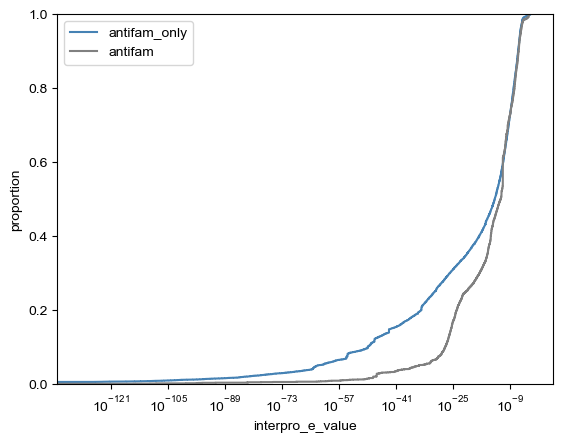

In [94]:
def figure(bacteria_antifam_annotation_df:pd.DataFrame, include_ids:list=[]):
    fig, ax = plt.subplots()

    ax_df = bacteria_antifam_annotation_df[bacteria_antifam_annotation_df.interpro_analysis == 'AntiFam'].copy()
    ax_df = ax_df.sort_values('interpro_e_value')
    ax_df = ax_df[~ax_df.index.duplicated(keep='first')]

    sns.ecdfplot(data=ax_df[ax_df.index.isin(include_ids)], x='interpro_e_value', ax=ax, label='antifam_only', color='steelblue')
    sns.ecdfplot(data=ax_df[~ax_df.index.isin(include_ids)], x='interpro_e_value', ax=ax, label='antifam', color='gray')
    ax.legend()
    ax.set_xscale('log')
    ax.set_ylabel('proportion')
    plt.show()

figure(bacteria_antifam_annotation_df, include_ids=include_ids)

In [21]:
# Downloaded SwissProt from the UniProt FTP site on 04.08.2025.
if not os.path.exists('../data/swissprot.csv'):
    swissprot_df = XMLFile('../data/swissprot.xml').to_df()
    swissprot_df.to_csv('../data/swissprot.csv')
else:
    swissprot_df = pd.read_csv('../data/swissprot.csv', index_col=0)

bacteria_swissprot_df = swissprot_df[swissprot_df.domain == 'Bacteria'].copy()
bacteria_swissprot_df.to_csv('../data/swissprot_bacteria.csv')
bacteria_swissprot_df = bacteria_swissprot_df[~bacteria_swissprot_df.index.duplicated(keep='first')]
FASTAFile(df=bacteria_swissprot_df).write('../data/swissprot_bacteria.faa')

In [3]:
def filter_length(df:pd.DataFrame, max_length:int=2000, seq_col:str='seq'):
    mask = df[seq_col].apply(len) >= max_length
    print(f'filter_length: Removing {mask.sum()} sequences exceeding the maximum length of {max_length}.')
    df = df[~mask].copy()
    return df

def filter_duplicate_sequences(df:pd.DataFrame, seq_col:str='seq'):
    # There are some duplicate IDs, as the same gene can be present in multiple genomes. Additionally, there are
    # some entries for identical sequences which do not have the same ID. This can mess up the bisecting k-means clustering, 
    # so I decided to remove these instances. 
    mask = df[seq_col].duplicated(keep='first')
    print(f'filter_duplicate_sequences: Removing {mask.sum()} duplicate sequences from the dataset')
    df = df[~mask].copy()
    return df 


In [90]:
def build_dataset(swissprot_path:str='../data/swissprot_bacteria.csv', antifam_path:str='../data/antifam_bacteria.csv', exclude_ids:list=[]):
    dataset_df = list()
    dataset_df += [pd.read_csv(swissprot_path, index_col=0).assign(library_entry_name='swissprot_bacteria', label=1)]
    dataset_df += [pd.read_csv(antifam_path, index_col=0).assign(library_entry_name='antifam_bacteria', label=0)]
    dataset_df = pd.concat(dataset_df)

    print(f'build_dataset: Removing {len(exclude_ids)} sequences from the dataset.')
    dataset_df = dataset_df[~dataset_df.index.isin(exclude_ids)]

    dataset_df = fillna(dataset_df, rules={str:'none', bool:False, int:0, float:0})
    dataset_df = filter_duplicate_sequences(dataset_df)
    dataset_df = filter_length(dataset_df)
    
    # For some reason, some of the taxonomy IDs map to different IDs in the NCBI database. 
    taxonomy_id_map = {369930:2576905, 1914757:1768011, 32059:477181, 2859001:2842348, 54064:334542}
    dataset_df['ncbi_taxonomy_id'] = dataset_df.ncbi_taxonomy_id.replace(taxonomy_id_map)

    print(f'build_dataset: Constructed a training dataset with {len(dataset_df)} sequences.')
    dataset_df.to_csv('../data/datasets/dataset.csv')

build_dataset(exclude_ids=exclude_ids)

build_dataset: Removing 2758 sequences from the dataset.
filter_duplicate_sequences: Removing 136496 duplicate sequences from the dataset
filter_length: Removing 148 sequences exceeding the maximum length of 2000.
build_dataset: Constructed a training dataset with 276590 sequences.


In [ ]:
dataset_df = pd.read_csv('../data/datasets/dataset.csv', index_col=0)
taxonomy_ids = dataset_df.ncbi_taxonomy_id.unique()
# Dowloaded taxonomy metadata from NCBI on 04.08.2025. 
ncbi = download.NCBI()
taxonomy_metadata_df = ncbi.get_taxonomy_metadata(taxonomy_ids, path='../data/datasets/dataset_taxonomy_metadata.tsv')

NCBI._get_metadata: Downloading metadata.: 100%|██████████| 373/373 [1:50:22<00:00, 17.75s/it]


NCBI.get_taxonomy_metadata: Writing metadata for 7448 taxa to ../data/datasets/dataset_taxonomy_metadata.tsv


In [96]:
def add_taxonomy_metadata(path:str='../data/datasets/dataset.csv'):
    taxonomy_metadata_df = pd.read_csv('../data/datasets/dataset_taxonomy_metadata.tsv', sep='\t', index_col=0)
    cols = ['Phylum name', 'Class name', 'Order name', 'Family name', 'Genus name', 'Species name']

    taxonomy_metadata_df = taxonomy_metadata_df[cols]
    taxonomy_metadata_df = taxonomy_metadata_df.rename(columns={col:col.split()[0].lower() for col in cols})
    taxonomy_metadata_df = fillna(taxonomy_metadata_df)

    dataset_df = pd.read_csv(path, index_col=0)
    assert np.all(np.isin(dataset_df.ncbi_taxonomy_id.unique(), taxonomy_metadata_df.index)), 'add_taxonomy_metadata: Some taxa are missing in the taxonomy metadata file.'
    dataset_df = dataset_df.drop(columns=taxonomy_metadata_df.columns, errors='ignore')
    dataset_df = dataset_df.merge(taxonomy_metadata_df, left_on='ncbi_taxonomy_id', right_index=True, how='left')
    dataset_df.to_csv(path)

add_taxonomy_metadata('../data/datasets/dataset.csv')
# add_taxonomy_metadata('../data/datasets/dataset_train.csv')
# add_taxonomy_metadata('../data/datasets/dataset_test.csv')


In [4]:
def table(path:str='../data/figures/dataset-table_1.png'):
    datasets = dict()
    datasets['dataset'] = pd.read_csv('../data/datasets/dataset.csv', index_col=0)
    datasets['train_dataset'] = pd.read_csv('../data/datasets/dataset_train.csv', index_col=0)
    datasets['test_dataset'] = pd.read_csv('../data/datasets/dataset_test.csv', index_col=0)

    percent_label = lambda df, label : f'{100 * (df.label == label).sum() / len(df):.2f}%'

    columns = ['size', 'fraction_of_dataset', 'percent_spurious', 'percent_real']
    table_df = pd.DataFrame(index=['dataset', 'train_dataset', 'test_dataset'], columns=columns)

    for dataset, df in datasets.items():
        table_df.loc[dataset, 'size'] = len(df)
        table_df.loc[dataset, 'fraction_of_dataset'] = f'{len(df) / len(datasets['dataset']):.2f}'
        table_df.loc[dataset, 'percent_spurious'] = percent_label(df, 0)
        table_df.loc[dataset, 'percent_real'] = percent_label(df, 1)

    return table_df

table()




,size,fraction_of_dataset,percent_spurious,percent_real
dataset,276590,1.00,6.23%,93.77%
train_dataset,221632,0.80,6.30%,93.70%
test_dataset,54958,0.20,5.95%,94.05%


In [102]:
# Want to try three different kinds of validation:
# (1) Model organisms, for which the annotated genomes will be the most reliable, and which have the most experimental support. 
# (2) Organisms from classes which are heavily-represented in the training data.
# (3) Organisms from classes which are not present in the training data. 
# For case (3), I want to be sure to not include exact species which are present in the traing data. 
# For all cases, I will limit myself to NCBI reference genomes. 

dataset_df = pd.read_csv('../data/datasets/dataset.csv', index_col=0)
genome_metadata_df = load_ncbi_genome_metadata() # Metadata for all available NCBI reference genomes. 

family_counts = dataset_df.value_counts('family').sort_values(ascending=False)
family_counts = family_counts[family_counts.index.isin(genome_metadata_df.family.unique())]
common_families = family_counts.iloc[:10].index # Get the top ten most common families. 

phyla = dataset_df.phylum.unique()
rare_phyla = np.unique([phylum for phylum in genome_metadata_df.phylum if (phylum not in phyla)]) # Phyla which are not present in the training data.

common_taxa = genome_metadata_df[genome_metadata_df.family.isin(common_families)].groupby('family').sample(5, random_state=42).index
rare_taxa = genome_metadata_df.index[genome_metadata_df.phylum.isin(rare_phyla)]
model_taxa = ['GCF_000005845.2', 'GCF_000009045.1','GCF_000006765.1', 'GCF_000195955.2']

genome_metadata_df.loc[rare_taxa].to_csv('../data/datasets/rare_taxa/rare_taxa_genome_metadata.csv')
genome_metadata_df.loc[common_taxa].to_csv('../data/datasets/common_taxa/common_taxa_genome_metadata.csv')
genome_metadata_df.loc[model_taxa].to_csv('../data/datasets/model_taxa/model_taxa_genome_metadata.csv')

In [ ]:
genome_ids = list(common_taxa) + list(rare_taxa) + list(model_taxa)

# Downloaded rare, model, and common taxa from NCBI on 04.08.2025.
# ncbi = download.NCBI()
# ncbi.get_genomes(genome_ids=genome_ids, include=['gbff', 'protein', 'genome'], dirs={'gbff':'../data/ncbi/gbffs/', 'protein':'../data/ncbi/proteins/', 'genome':'../data/ncbi/genomes/'})
# ncbi.cleanup()

# prodigal = Prodigal()
# for genome_id in tqdm(genome_ids):
#     prodigal.run(f'../data/ncbi/genomes/{genome_id}_genomic.fna', f'../data/prodigal/{genome_id}_protein.faa')

# query_paths = [f'../data/prodigal/{genome_id}_protein.faa' for genome_id in common_taxa]
# reference_paths = [f'../data/ncbi/gbffs/{genome_id}_genomic.gbff' for genome_id in common_taxa]
# for query_path, reference_path in zip(query_paths, reference_paths):
#     compare(query_path, reference_path, overwrite=True)

In [ ]:
dataset_df = pd.read_csv('../data/datasets/dataset.csv', index_col=0)

In [ ]:
def build_dataset_prodigal(genome_ids):
    dataset_df = list()
    for genome_id in genome_ids:
        df = Reference.load(f'../data/compare/{genome_id}_top_hits.csv')
        df['genome_id'] = genome_id
        dataset_df.append(df)
    return pd.concat(dataset_df)

df = build_dataset_prodigal(rare_taxa)

In [ ]:
def build_taxa_dataset(genome_ids:list, name='model_taxa'):
    pass 

In [ ]:
dataset_df[dataset_df.domain == 'Bacteria'].phylum.nunique()

91

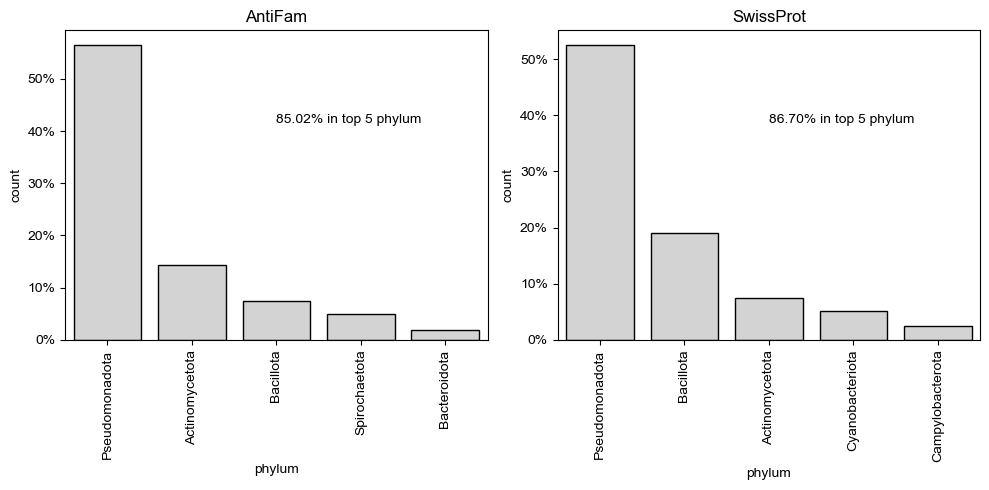

In [107]:
def figure(dataset_df:pd.DataFrame, level:str='genus', top_n:int=5):

    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

    for ax, (_, df) in zip(axes, dataset_df.groupby('label')):
        ax_df = df.value_counts(level)
        ax_df = ax_df / ax_df.sum() * 100
        ax_df = ax_df[ax_df.index != 'none'].copy()
        ax_df = ax_df.iloc[:top_n]

        sns.barplot(data=ax_df, ax=ax, color='lightgray', edgecolor='black')

        if (level == 'species'):
            x_tick_labels = [f'{taxon.split()[0][0]}. {taxon.split()[-1]}' for taxon in ax_df.index]
            ax.set_xticks(np.arange(len(ax_df)), labels=x_tick_labels, rotation=90, fontstyle='italic')
        else:
            ax.set_xticks(np.arange(len(ax_df)), labels=ax_df.index, rotation=90)
        ax.yaxis.set_major_formatter(tick.PercentFormatter())
        ax.text(0.5, 0.7, f'{ax_df.sum():.2f}% in top {top_n} {level}', transform=ax.transAxes)

    axes[0].set_title('AntiFam')
    axes[1].set_title('SwissProt')

    fig.tight_layout()
    plt.show()

figure(dataset_df, level='phylum')

In [ ]:
cluster_df = pd.read_csv('../data/datasets/dataset_cluster.csv', index_col=0)
len(cluster_df)

278583

In [ ]:
len(dataset_df)

278583

In [ ]:
# What is a good estimate for the number of clusters? Maybe use 50 percent sequence similarity?
# This resulted in about 70000 clusters for the Campylobacterota dataset. 
# This resulted in about 665000 clusters for the SwissProt dataset. 
# mmseqs = MMSeqs()
# mmseqs_cluster_df = mmseqs.cluster(dataset_df, name='dataset', output_dir='../data/datasets/swissprot', sequence_identity=0.5, overwrite=False)
# mmseqs.cleanup()
# print('Number of clusters:', mmseqs_cluster_df.mmseqs_cluster_id.nunique())

In [ ]:
dataset_df = pd.read_csv('../data/dataset_dereplicated.csv', index_col=0)
dataset_df = dataset_df.merge(pd.read_csv('../data/dataset_dereplicated_cluster.csv', index_col=0), left_index=True, right_index=True)

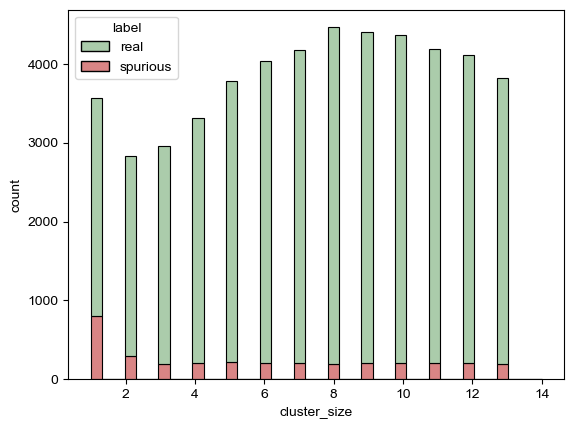

In [ ]:
fig, ax = plt.subplots()

ax_df = pd.DataFrame(index=dataset_df.cluster_label.unique())
ax_df['cluster_size'] = dataset_df.groupby('cluster_label').apply(len, include_groups=False)
ax_df['label'] = dataset_df.groupby('cluster_label').label.first()
ax_df['label'] = ax_df.label.replace({0:'spurious', 1:'real'})

palette = {'spurious':'indianred', 'real':'darkseagreen'}

sns.histplot(data=ax_df, x='cluster_size', hue='label', multiple='stack', ax=ax, palette=palette)
ax.set_ylabel('count')

plt.show()

In [ ]:
sequence_identities_df = list()
min_sequence_identity = 1

pbar = tqdm(list(dataset_df.groupby('cluster_label')), desc='Computing sequence identities.')
for cluster_label, df in pbar:
    values = get_sequence_identities(df, as_matrix=False)

    row = dict()
    row['cluster_label'] = cluster_label
    row['mean_sequence_identity'] = values.mean()
    row['min_sequence_identity'] = values.min()
    row['max_sequence_identity'] = values.max()
    row['standard_deviation'] = np.std(values)
    row['n_alignments'] = len(values)
    
    sequence_identities_df.append(row)

    if row['min_sequence_identity'] < min_sequence_identity:
        min_sequence_identity = row['min_sequence_identity']
        pbar.set_description(f'Computing sequence identities. Minimum identity {min_sequence_identity:.2f} found in cluster {cluster_label}.')

pbar.close()
sequence_identities_df = pd.DataFrame(sequence_identities_df).set_index('cluster_label')
sequence_identities_df.to_csv('dataset_dereplicated_cluster_sequence_identities.csv')

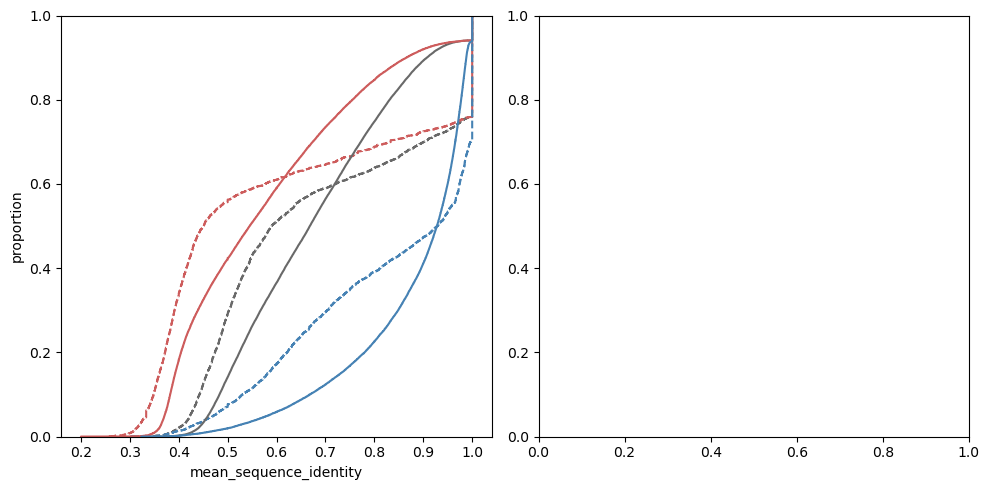

In [ ]:
sequence_identities_df = pd.read_csv('dataset_dereplicated_cluster_sequence_identities.csv', index_col=0)

fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

ax_a_df = sequence_identities_df.copy()
ax_a_df['label'] = dataset_df.groupby('cluster_label').label.first()
palette = {'spurious':'indianred', 'real':'darkseagreen'}

linestyles = {0:'--', 1:'-'}
for label, df in ax_a_df.groupby('label'):
    sns.ecdfplot(data=df, x='mean_sequence_identity', ax=ax_a, color='dimgray', label='mean sequence identity', linestyle=linestyles[label])
    sns.ecdfplot(data=df, x='min_sequence_identity', ax=ax_a, color='indianred', label='min. sequence identity', linestyle=linestyles[label])
    sns.ecdfplot(data=df, x='max_sequence_identity', ax=ax_a, color='steelblue', label='max. sequence identity', linestyle=linestyles[label])
ax_a.set_ylabel('proportion')

ax_b_df = pd.DataFrame(index=dataset_train_df.cluster_label.unique())

ax_b_df['cluster_size'] = ax_b_df.index.map(dataset_df.groupby('cluster_label').apply(len, include_groups=False))
# ax_b_df = ax_b_df.merge(sequence_identities_df, left_index=True, right_index=True)
# ax_b_df = ax_b_df.sort_values('min_sequence_identity').copy().iloc[:1000]

# sns.scatterplot(data=ax_b_df, x='min_sequence_identity', y='max_sequence_identity', ax=ax_b, color='dimgray')

fig.tight_layout()
plt.show()

In [ ]:

prodigal_df = list()
for genome_id in genome_ids:
    top_hits_df = Reference.load(f'../data/compare/{genome_id}_top_hits.csv')
    top_hits_df['genome_id'] = genome_id
    prodigal_df.append(top_hits_df)
prodigal_df = pd.concat(prodigal_df)
prodigal_df = filter_length(prodigal_df)


Removing 383 sequences which exceed the maximum length.
